In [1]:
import numpy as np 
import pandas as pd 
import os
import matplotlib.pyplot as plt 
import seaborn as sns 
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import re
import nltk
from nltk.corpus import stopwords
from tqdm import tqdm
from nltk.stem import WordNetLemmatizer
import spacy

tqdm.pandas()
spacy_eng = spacy.load("en_core_web_sm")
lemm = WordNetLemmatizer()
sns.set_style("darkgrid")
plt.rcParams['figure.figsize'] = (20,8)
plt.rcParams['font.size'] = 18
nltk.download()

NLTK Downloader
---------------------------------------------------------------------------
    d) Download   l) List    u) Update   c) Config   h) Help   q) Quit
---------------------------------------------------------------------------


Downloader>  d



Download which package (l=list; x=cancel)?


  Identifier>  all


       | 
       | Downloading package abc to /usr/share/nltk_data...
       |   Package abc is already up-to-date!
       | Downloading package alpino to /usr/share/nltk_data...
       |   Package alpino is already up-to-date!
       | Downloading package averaged_perceptron_tagger to
       |     /usr/share/nltk_data...
       |   Package averaged_perceptron_tagger is already up-to-date!
       | Downloading package averaged_perceptron_tagger_ru to
       |     /usr/share/nltk_data...
       |   Unzipping taggers/averaged_perceptron_tagger_ru.zip.
       | Downloading package basque_grammars to
       |     /usr/share/nltk_data...
       |   Package basque_grammars is already up-to-date!
       | Downloading package biocreative_ppi to
       |     /usr/share/nltk_data...
       |   Package biocreative_ppi is already up-to-date!
       | Downloading package bllip_wsj_no_aux to
       |     /usr/share/nltk_data...
       |   Package bllip_wsj_no_aux is already up-to-date!
       | Down


---------------------------------------------------------------------------
    d) Download   l) List    u) Update   c) Config   h) Help   q) Quit
---------------------------------------------------------------------------


Downloader>  q


True

# Twitter Tweets Sentiment Classification
- Sentiment classification is the automated process of identifying opinions in text and labeling them as positive, negative, or neutral, based on the emotions customers express within them
- Here since the labelled data that we have only has 2 classes, 0-Negative, 4-Positive (later encoded as 1) we will perform a binary classification

<img src='https://miro.medium.com/max/1196/1*LTpcCt2mYa2-edjdti8S4Q.jpeg'>

# Data Import
- Reading and sampling the data
- Since the data contains 1.6m records, it is not possible to create a feature vector of this size with atleast 1000-2000 reasonable features
- Therefore we randomly sample out 100000 records for our training and validation

In [2]:
data = pd.read_csv("../input/sentiment140/training.1600000.processed.noemoticon.csv",encoding = "latin",header=None)
data = data.iloc[:,[5,0]]
data.columns = ['Text','Class']
data = data.sample(102000)
data.reset_index(drop=True,inplace=True)
data.head(10)

,Text,Class
0,home and...going shopping,0
1,Said i would,4
2,@misspearlygates you should! But make sure it...,4
3,at home playing with Jadon. He lost his first ...,4
4,"&quot;Amanda Seyfried, sweet as Sophie, holds ...",4
5,"Its raining outside! How rad! At least, I can...",4
6,@Niqqua yeah i could dig it. who doesn't hate ...,0
7,I wish I was with my mom on Mother's day! I'l...,0
8,Wild week...filled with soo much to do! Finis...,4
9,"a new youtube account, probably just originall...",4


# Text Cleaning
1. Removal of extra spaces, lines and indentations
2. Removal of special characters like punctuations and emojis
3. Conversion of text into lower case
4. Tokenization
5. Filtering and removal of stopwords
6. Lemmatization

While other steps are fairly easy to understand, given below is an example of lemmatization (Stemming can also be used as an alternative, but lets say we are more interested in the intelligible root words so we will go with Lemmatization)

__Example of Lemmatization__
<img src='https://user.oc-static.com/upload/2020/10/22/16033589274175_lemmatization%20example%2001.png'>

In [3]:
stop_words = stopwords.words('english')
stop_words.remove('not')

def text_cleaning(x):
    
    text = re.sub('\s+\n+', ' ', x)
    text = re.sub('[^a-zA-Z0-9]', ' ', x)
    text = re.sub('^\S', ' ', x)
    text = text.lower()
    text = text.split()
    
    text = [lemm.lemmatize(word, "v") for word in text if word not in stop_words]
    text = ' '.join(text)
    
    return text

In [4]:
data['Clean Text'] = data['Text'].progress_apply(text_cleaning)

100%|██████████| 102000/102000 [00:11<00:00, 8876.47it/s] 


In [5]:
data.head(10)

,Text,Class,Clean Text
0,home and...going shopping,0,ome and...going shop
1,Said i would,4,aid would
2,@misspearlygates you should! But make sure it...,4,misspearlygates should! make sure sub version ...
3,at home playing with Jadon. He lost his first ...,4,"home play jadon. lose first tooth today, liter..."
4,"&quot;Amanda Seyfried, sweet as Sophie, holds ...",4,"quot;amanda seyfried, sweet sophie, hold play ..."
5,"Its raining outside! How rad! At least, I can...",4,"ts rain outside! rad! least, breath fresh air"
6,@Niqqua yeah i could dig it. who doesn't hate ...,0,niqqua yeah could dig it. hate lose lease reje...
7,I wish I was with my mom on Mother's day! I'l...,0,wish mom mother's day! i'll home soon.
8,Wild week...filled with soo much to do! Finis...,4,ild week...filled soo much do! finish work wee...
9,"a new youtube account, probably just originall...",4,"new youtube account, probably originally make ..."


In [6]:
data.isna().sum()

Text          0
Class         0
Clean Text    0
dtype: int64

In [7]:
data.loc[data['Class']==4,'Class'] = 1
data['Class'].value_counts()

0    51032
1    50968
Name: Class, dtype: int64

# EDA and Visualization
- Exploring class count distribution
- Frequently occuring words in negative and positive tweets
- Sentence Length Distribution Analysis

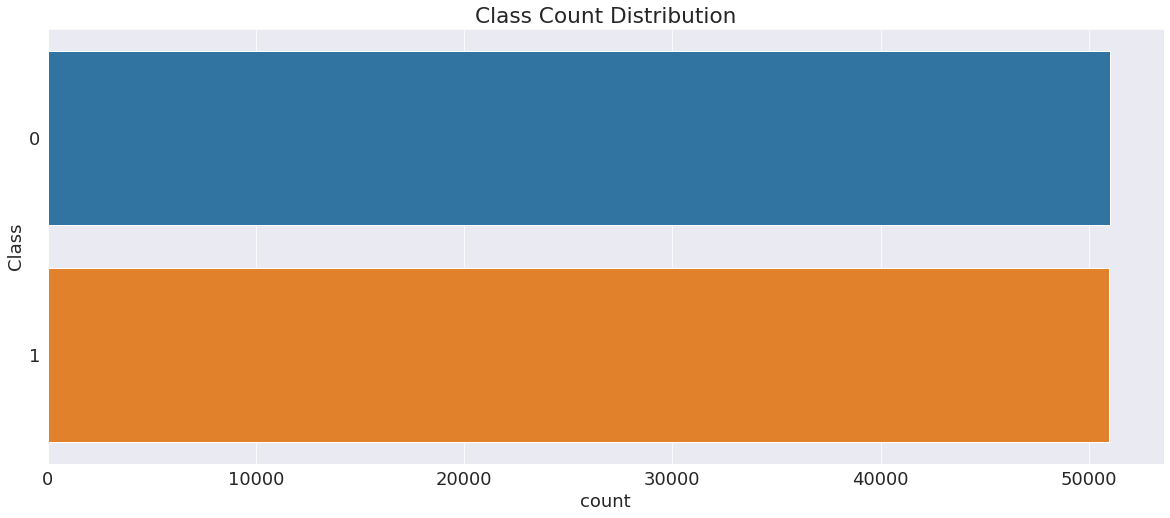

In [8]:
sns.countplot(data=data,y='Class')
plt.title("Class Count Distribution")
plt.show()

In [9]:
positive = data[data['Class']==1]['Clean Text'].tolist()
negative = data[data['Class']==0]['Clean Text'].tolist()

## WordClouds and Barplots of Frequently Occuring words

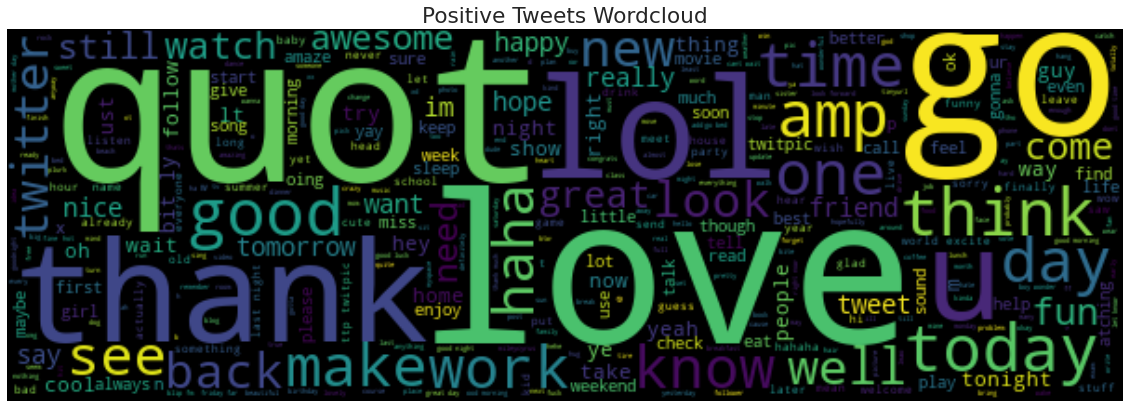

In [45]:
wordcloud = WordCloud(max_words=1500, width=600, background_color='black').generate(" ".join(positive))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title("Positive Tweets Wordcloud")
plt.axis("off")
plt.show()

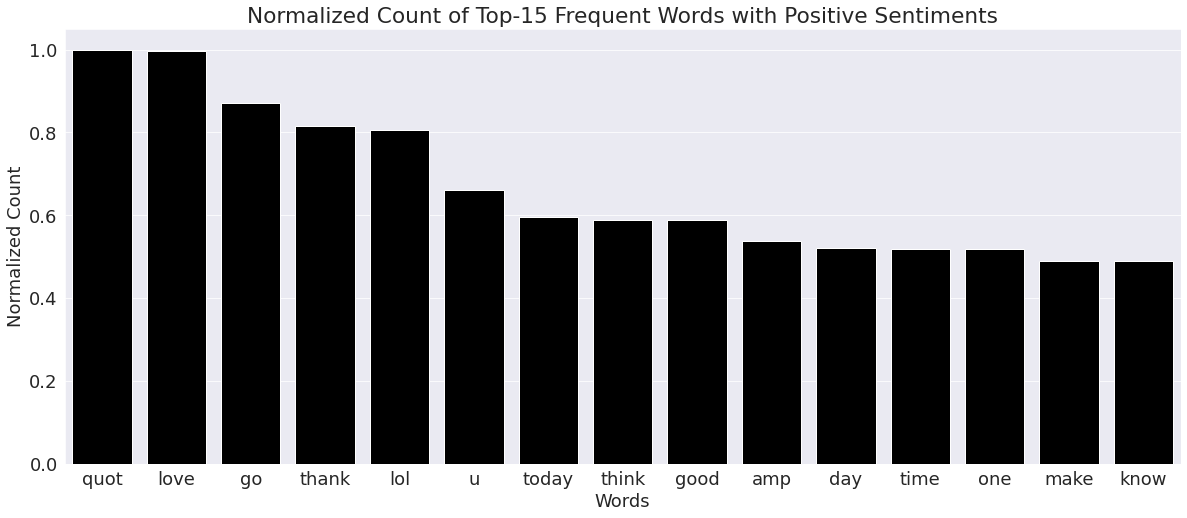

In [15]:
x = []
y = []
for key,value in wordcloud.words_.items():
    x.append(key)
    y.append(value)
    if len(x) == 15:
        break
sns.barplot(x=x,y=y,color='black')
plt.title("Normalized Count of Top-15 Frequent Words with Positive Sentiments")
plt.xlabel("Words")
plt.ylabel("Normalized Count")
plt.show()

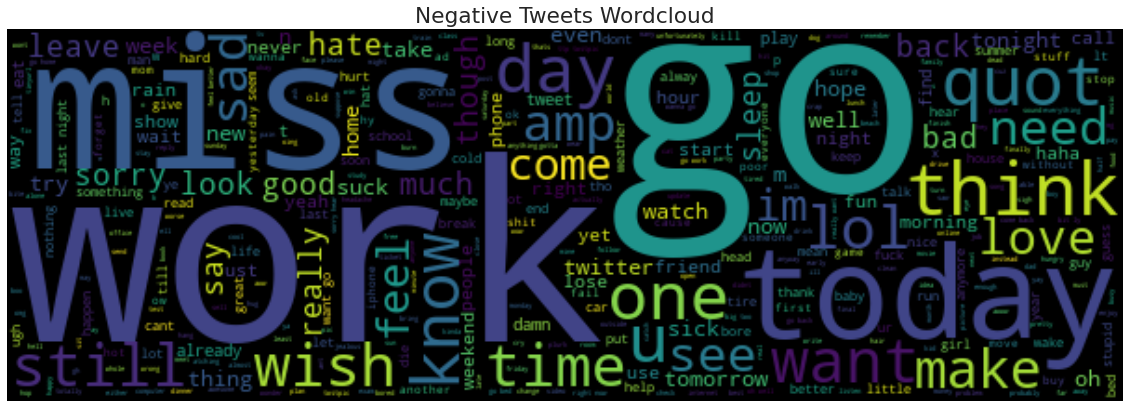

In [46]:
wordcloud = WordCloud(max_words=1500, width=600, background_color='black').generate(" ".join(negative))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title("Negative Tweets Wordcloud")
plt.axis("off")
plt.show()

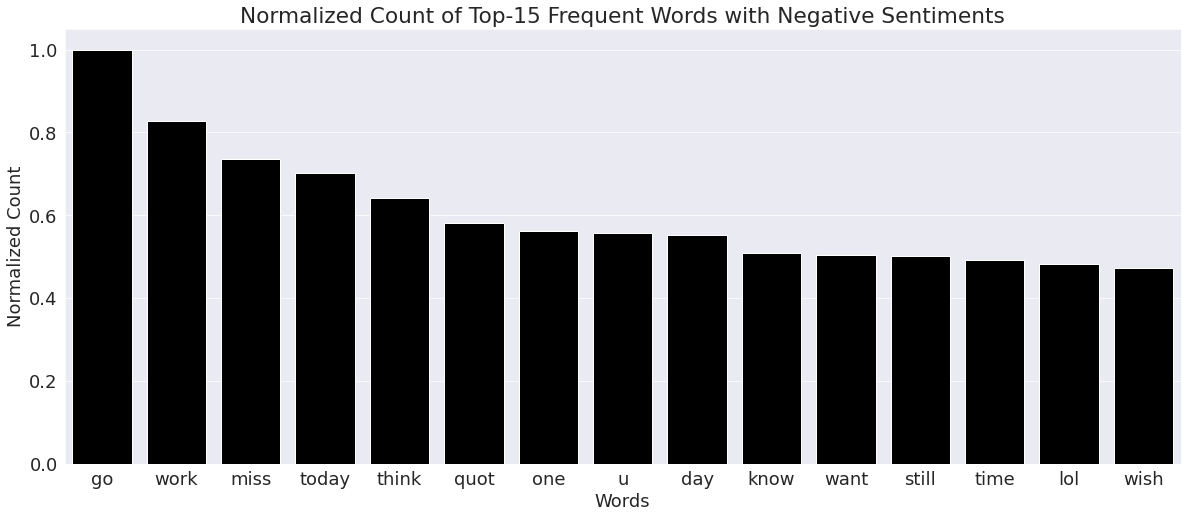

In [47]:
x = []
y = []
for key,value in wordcloud.words_.items():
    x.append(key)
    y.append(value)
    if len(x) == 15:
        break
sns.barplot(x=x,y=y,color='black')
plt.title("Normalized Count of Top-15 Frequent Words with Negative Sentiments")
plt.xlabel("Words")
plt.ylabel("Normalized Count")
plt.show()

In [18]:
data['sentence_length'] = data['Clean Text'].progress_apply(lambda x: len(x.split()))

100%|██████████| 102000/102000 [00:00<00:00, 468689.17it/s]


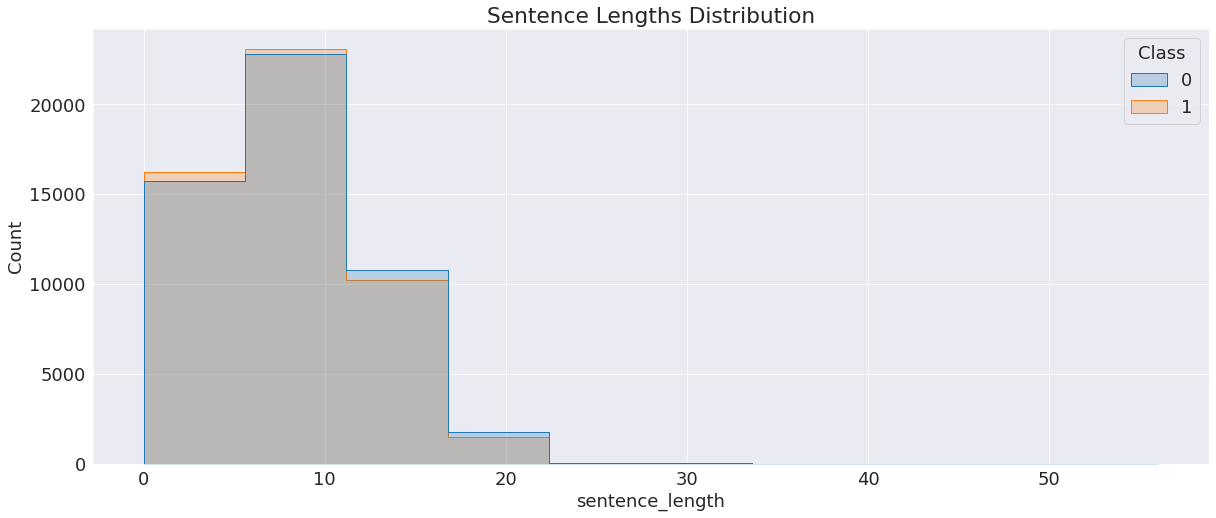

In [19]:
sns.histplot(data=data,x='sentence_length',hue='Class',bins=10, element='step')
plt.title("Sentence Lengths Distribution")
plt.show()

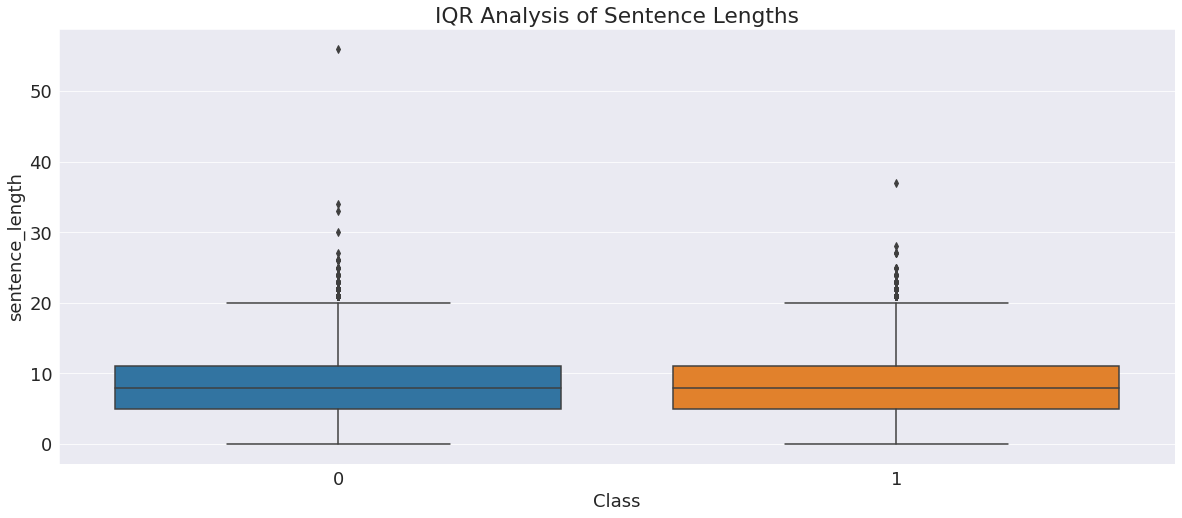

In [20]:
sns.boxplot(data=data,y='sentence_length',x='Class')
plt.title("IQR Analysis of Sentence Lengths")
plt.show()

In [21]:
data['sentence_length'].describe()

count    102000.000000
mean          8.247735
std           4.219477
min           0.000000
25%           5.000000
50%           8.000000
75%          11.000000
max          56.000000
Name: sentence_length, dtype: float64

In [22]:
test = data.tail(2000)
data = data.iloc[:100000,:]

# Feature Extraction and Modelling
- Extracting features using TF-iDF extraction method
- We will avoid using Count Vectorizer over here since the document is very large and certain words might get too high values/importance based on their presence in the entire document corpus, and since we want to focus on the relative presence of different kinds of words in the text, TF-iDF will be a more preferred choice of feature extraction

<img src='https://miro.medium.com/max/1200/1*V9ac4hLVyms79jl65Ym_Bw.jpeg'>

In [25]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

In [26]:
vectorizer = TfidfVectorizer(ngram_range=(1,2), max_features=2500)
X = vectorizer.fit_transform(data['Clean Text'].values.tolist()).toarray()
y = data['Class'].values

In [27]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42)

In [28]:
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, roc_auc_score

In [29]:
def model_train(model, X_train, X_test, y_train, y_test):
    model.fit(X_train,y_train)
    y_pred_tr = model.predict(X_train)
    y_pred = model.predict(X_test)

    print("--------------------Training Performance---------------------")
    print(classification_report(y_train,y_pred_tr))
    print("-------------------------------------------------------------")
    print("--------------------Testing Performance----------------------")
    print(classification_report(y_test,y_pred))
    
    sns.heatmap(confusion_matrix(y_test, y_pred),cmap='viridis',annot=True,fmt='.4g',
            xticklabels=['Negative','Positive'],yticklabels=['Negative','Positive'])
    plt.xlabel('Predicted Class')
    plt.ylabel('Actual Class')
    plt.show()
    
    fpr, tpr, _ = roc_curve(y_test,  y_pred)
    auc = roc_auc_score(y_test, y_pred)
    plt.plot(fpr,tpr,label="CNN Model, auc="+str(auc),lw=2)
    plt.plot([0, 1], [0, 1], color="orange", lw=2, linestyle="--")
    plt.title("ROC Curve")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend(loc=4)
    plt.show()

## Navie Bayes

--------------------Training Performance---------------------
              precision    recall  f1-score   support

           0       0.75      0.77      0.76     40050
           1       0.76      0.74      0.75     39950

    accuracy                           0.76     80000
   macro avg       0.76      0.76      0.76     80000
weighted avg       0.76      0.76      0.76     80000

-------------------------------------------------------------
--------------------Testing Performance----------------------
              precision    recall  f1-score   support

           0       0.73      0.75      0.74      9968
           1       0.75      0.73      0.74     10032

    accuracy                           0.74     20000
   macro avg       0.74      0.74      0.74     20000
weighted avg       0.74      0.74      0.74     20000



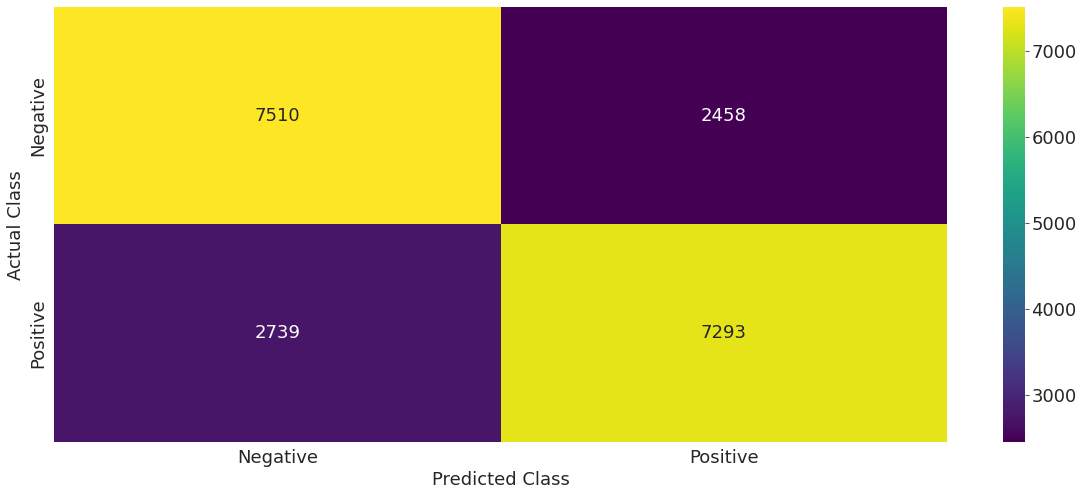

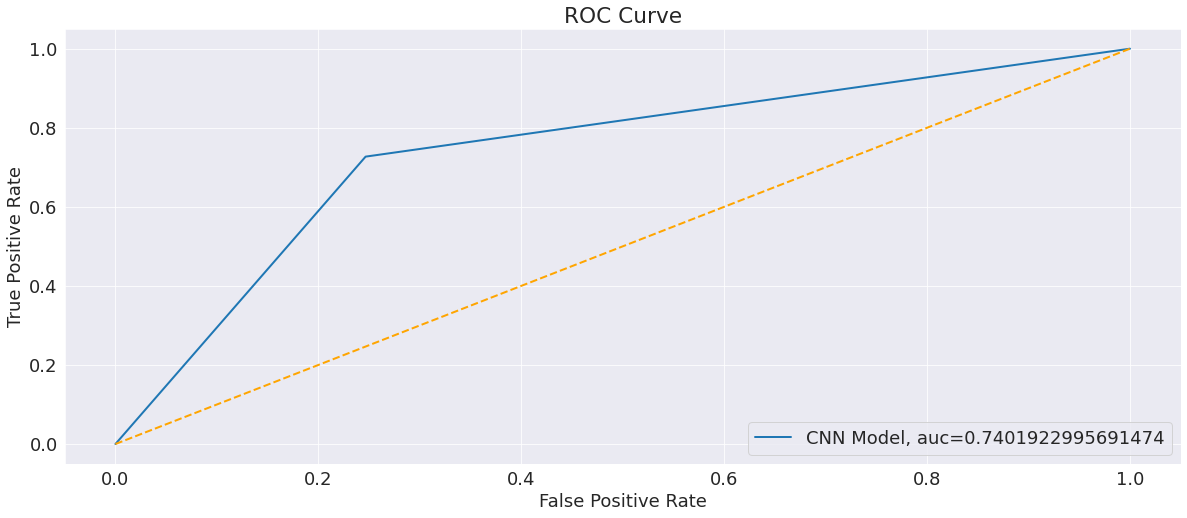

In [30]:
model = MultinomialNB()
model_train(model, X_train, X_test, y_train, y_test)

## Logistic Regression
- Max iterations is set to 1000, so that the model can run for more iterations for convergence
- With its default number of iterations (100) the model fails to converge

--------------------Training Performance---------------------
              precision    recall  f1-score   support

           0       0.79      0.75      0.77     40050
           1       0.76      0.80      0.78     39950

    accuracy                           0.77     80000
   macro avg       0.77      0.77      0.77     80000
weighted avg       0.77      0.77      0.77     80000

-------------------------------------------------------------
--------------------Testing Performance----------------------
              precision    recall  f1-score   support

           0       0.76      0.74      0.75      9968
           1       0.75      0.77      0.76     10032

    accuracy                           0.75     20000
   macro avg       0.76      0.75      0.75     20000
weighted avg       0.76      0.75      0.75     20000



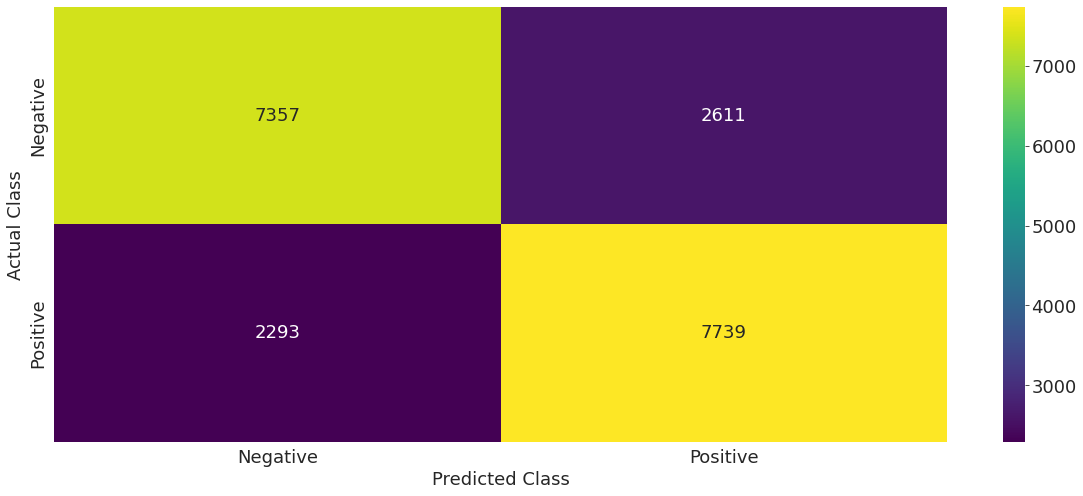

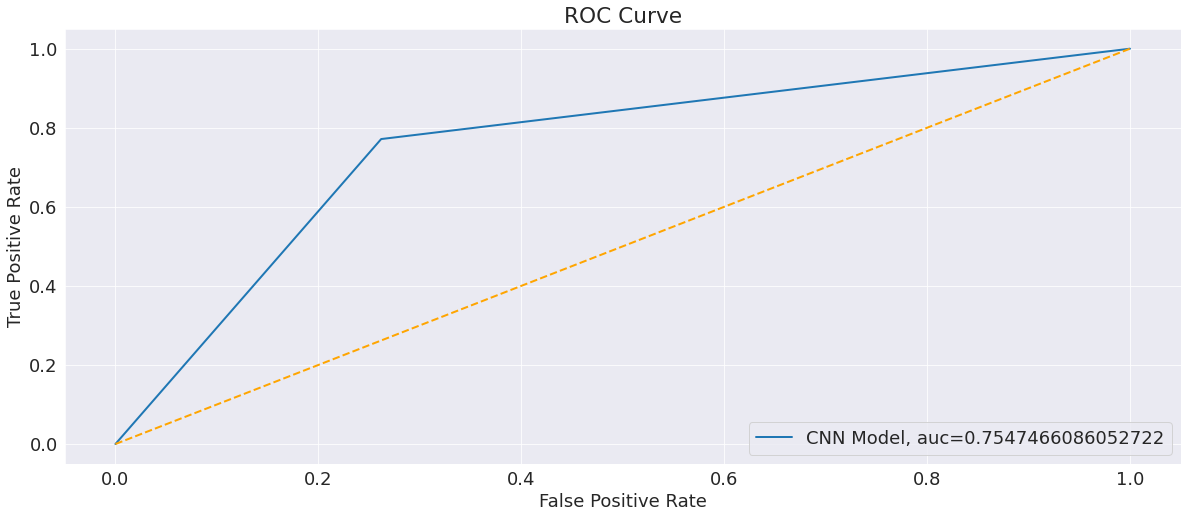

In [31]:
model = LogisticRegression(max_iter=1000)
model_train(model, X_train, X_test, y_train, y_test)

## Random Forest
- Uses 100 decision trees to perform bagging and produce and ensemble result
- Max depth is set to 15 to avoid overfitting on the training set
- Max features have been set sqrt of the number of features (performs slightly better than log and auto)

--------------------Training Performance---------------------
              precision    recall  f1-score   support

           0       0.77      0.61      0.68     40050
           1       0.68      0.82      0.74     39950

    accuracy                           0.71     80000
   macro avg       0.72      0.71      0.71     80000
weighted avg       0.72      0.71      0.71     80000

-------------------------------------------------------------
--------------------Testing Performance----------------------
              precision    recall  f1-score   support

           0       0.74      0.60      0.66      9968
           1       0.66      0.79      0.72     10032

    accuracy                           0.69     20000
   macro avg       0.70      0.69      0.69     20000
weighted avg       0.70      0.69      0.69     20000



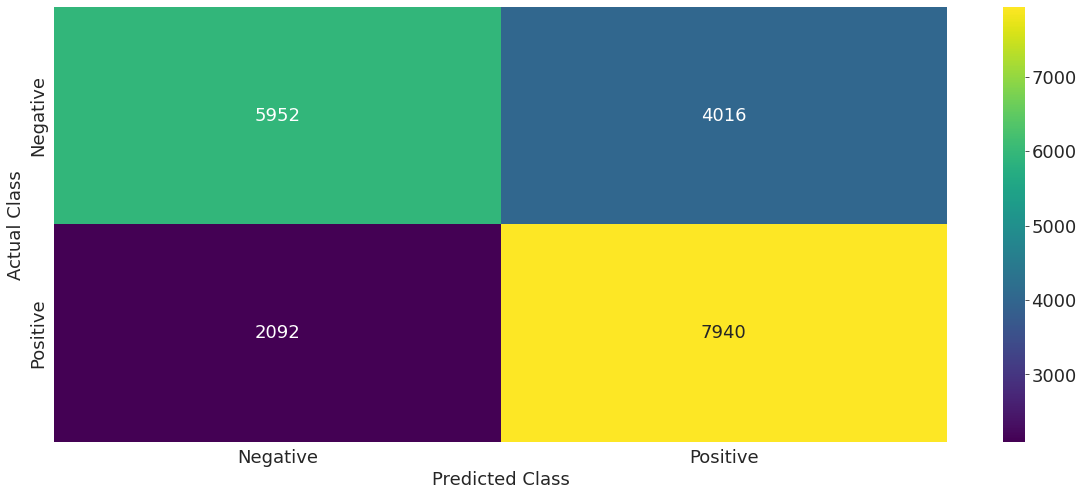

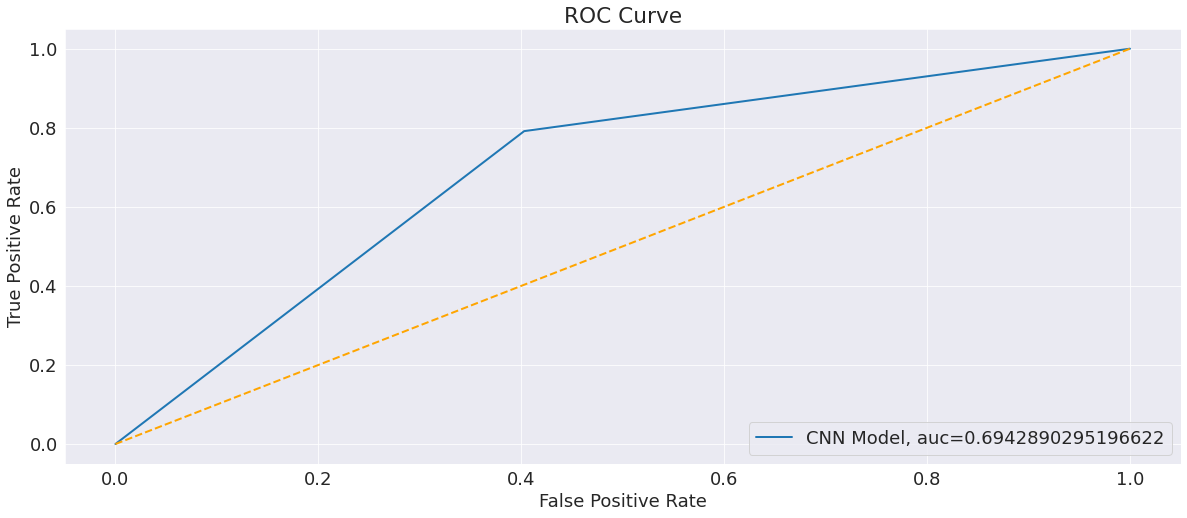

In [32]:
model = RandomForestClassifier(n_estimators=100,max_depth=15,max_features='sqrt')
model_train(model, X_train, X_test, y_train, y_test)

| Model | F1-Score | Accuracy | AUC Score |
| --- | --- | --- | --- |
| Naive Bayes | 0.75 | 0.75 | 0.75 |
| __Logistic Regression__ | 0.76 | 0.76 | 0.758 |
| Naive Bayes | 0.70 | 0.70 | 0.69 |

__Inference:__ Based on the Accuracy, F1-Score and AUC Score Logistic Regression performs the best on the validation set

# Post Feature Extraction Analysis 
- Here we will apply PCA just for the sake of visualizing how the data looks on a 2D plane
- Since the number of records and features are very high it is difficult to look at the correlation and reason with it to apply PCA

In [33]:
from sklearn.decomposition import PCA

In [34]:
pca = PCA()
X_pca = pca.fit_transform(X_train)
variance_explained = np.cumsum(pca.explained_variance_ratio_)
pcs = range(1,len(variance_explained)+1)

## Analysing the Variance Explanantion
- 2 components will explain even less than 15% of the total variance of our feature extracted data, but will try to visualize it regardless
- It will still require over 2000 components to represent more than 90% of the variance of the data, seems like there is not much correlation in the feature extracted data, which is justified since it is a sparse matrix

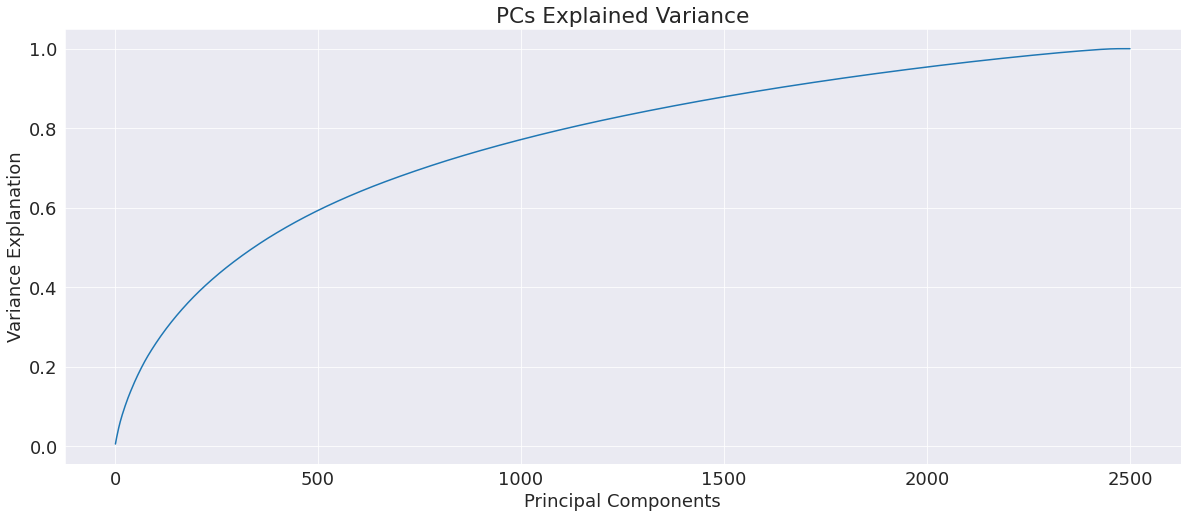

In [35]:
plt.plot(pcs,variance_explained)
plt.title("PCs Explained Variance")
plt.xlabel("Principal Components")
plt.ylabel("Variance Explanation")
plt.show()

## Training Set

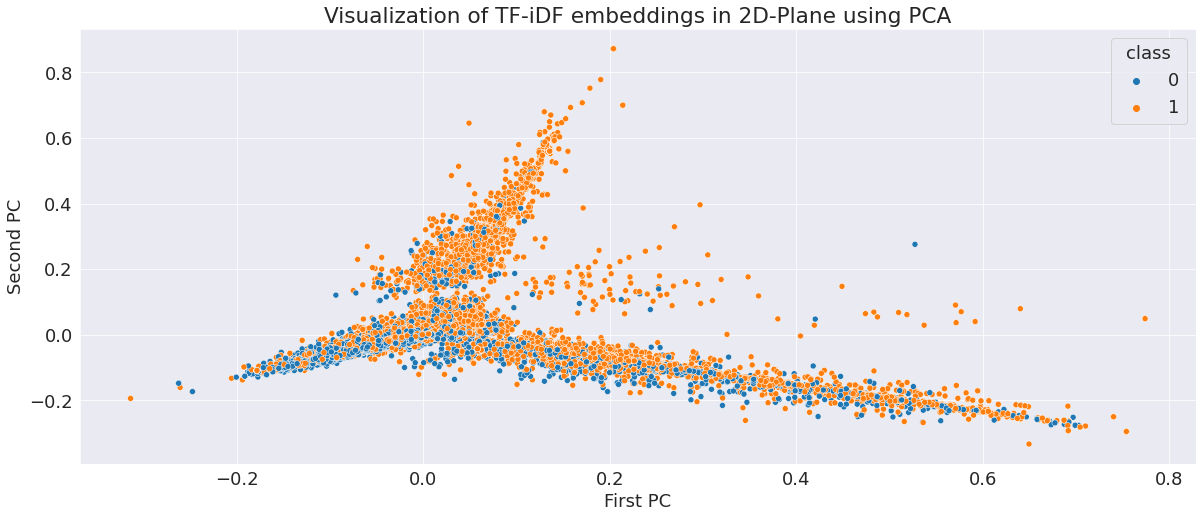

In [36]:
vis_df = pd.DataFrame(X_pca[:,:2])
vis_df['class'] = y_train

sns.scatterplot(x=0,y=1,data=vis_df,hue='class')
plt.title("Visualization of TF-iDF embeddings in 2D-Plane using PCA")
plt.xlabel("First PC")
plt.ylabel("Second PC")
plt.show()

## Validation Set

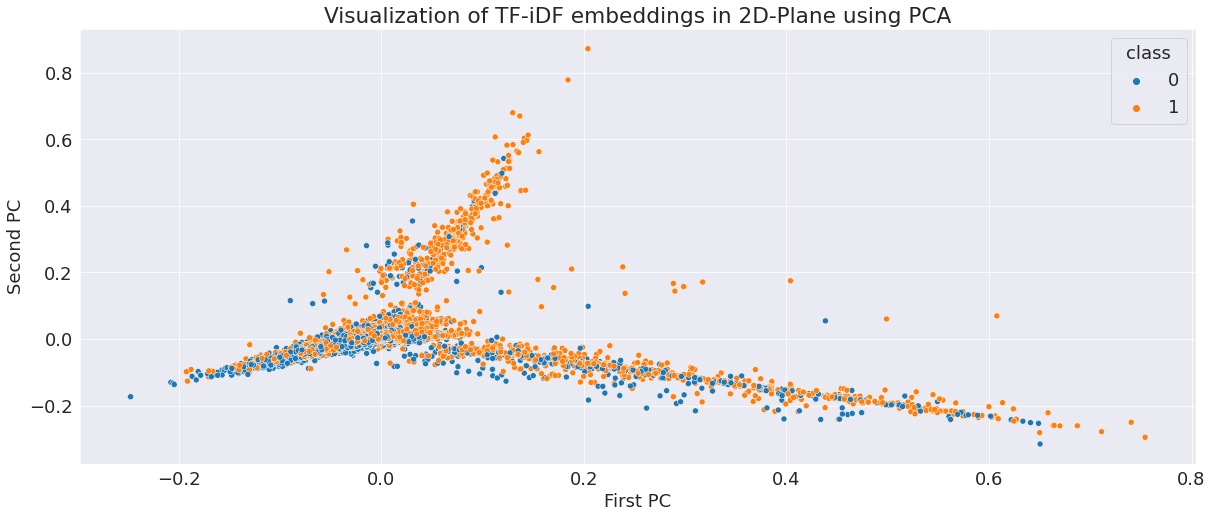

In [37]:
X_test_pca = pca.transform(X_test)
vis_df = pd.DataFrame(X_test_pca[:,:2])
vis_df['class'] = y_test

sns.scatterplot(x=0,y=1,data=vis_df,hue='class')
plt.title("Visualization of TF-iDF embeddings in 2D-Plane using PCA")
plt.xlabel("First PC")
plt.ylabel("Second PC")
plt.show()

__Inference__: No clear distinctice pattern as expected, the non linearities however can be captured using feed forward neural nets or some other non linear models

# Inference Pipeline
- Lets put the above feature extraction and modelling steps inside a pipeline

<img src='https://miro.medium.com/max/1400/1*ah8eEa2j4NULlMUts6UFNA.png'>

## Test Set

In [38]:
from sklearn.pipeline import Pipeline

In [40]:
model = LogisticRegression(max_iter=1000)
model.fit(X_train,y_train)
pipe = Pipeline([('feature_extraction', vectorizer), ('logit', model)])

In [41]:
test_input = test['Clean Text'].tolist()
test_label = test['Class']

In [43]:
outputs = pipe.predict(test_input)

In [44]:
print(classification_report(test_label,outputs))

              precision    recall  f1-score   support

           0       0.77      0.73      0.75      1014
           1       0.73      0.78      0.76       986

    accuracy                           0.75      2000
   macro avg       0.75      0.75      0.75      2000
weighted avg       0.75      0.75      0.75      2000



<p style='font-size: 18px'><strong>Conclusion:</strong> The model gives same performance on the previously unseen non preprocessed test set as well</p>